# Process Gajjar Bursts

This notebook computes the burst drift for the Gajjar bursts

In [106]:
#!/usr/bin/python3

from __future__ import division
import math
import os
import sys
import time
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
from math import log10
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import pi as nombrepi
from scipy import signal, ndimage
from tqdm import tqdm
from matplotlib import colors as mcolors
import functools
print = functools.partial(print, flush=True) # print doesn't happen til script ends so force it to flush... windows thing?
import pandas as pd

bursts = pd.read_csv('bursts.csv')

# Gaussian 2d Fit Stuff Based on:
# Source: https://gist.github.com/andrewgiessel/6122739
# Source: https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
def gaussian(height, center_x, center_y, width_x, width_y, rotation):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)

    rotation = np.deg2rad(rotation)
    center_x_old = center_x
    center_x = center_x * np.cos(rotation) - center_y * np.sin(rotation)
    center_y = center_x_old * np.sin(rotation) + center_y * np.cos(rotation)

    def rotgauss(x,y):
        xp = x * np.cos(rotation) - y * np.sin(rotation)
        yp = x * np.sin(rotation) + y * np.cos(rotation)
        g = height*np.exp( -(((center_x-xp)/width_x)**2  +((center_y-yp)/width_y)**2)/2.  )
        return g
    return rotgauss

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 2.0

def twoD_Gaussian(point, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = point
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = (np.sin(2*theta))/(2*sigma_x**2) - (np.sin(2*theta))/(2*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - a*((x-xo)**2) - b*(x-xo)*(y-yo) - c*((y-yo)**2))
    return g.ravel()

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = scipy.optimize.leastsq(errorfunction, params)
    return p, success

def fitgaussiannlsq(data):
    # use curve-fit (non-linear leastsq)
    x, y = np.indices(data.shape)
    params = moments(data)#+ (0.,)
    popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x, y), corr.ravel(), p0=params)
    return popt, pcov

In [23]:
folder = 'data'
outfolder = 'figures'
for burst, filename, edge in tqdm( zip(range(1, len(bursts['filename'])+1), bursts['filename'], bursts['edge']), total=len(bursts['filename']) ):
    if 'gajjar' not in filename:
        continue
    if burst is not 18:
        continue
    print('processing {}'.format(filename))
    if burst is 17: burst = '11A'
    if burst is 18: burst = '11D'

    junk, nchan, nbin, I, Q, U, V = np.loadtxt('{}/{}'.format(folder, filename), delimiter=' ', unpack=True)
    Q, U, V = None, None, None
    n = len(junk)
    print("Data loaded")
    

    binmax = int(nbin[n-1])+1
    frequencymax = (int(nchan[n-1])+1)
    intensity = np.zeros((frequencymax, binmax))

    X = np.zeros(binmax)
    Y = np.zeros(frequencymax)

    # what are these?
    if burst is '11A':
        tmin, tmax = 1, 500
    if burst is '11D':
        tmin, tmax = 1, 250
    else:
        tmin, tmax = 500, 1500

    #### 1. remove noise
    intensitynoise1 = np.zeros(tmin-1)
    intensitynoise2 = np.zeros(binmax-tmax)
    intensityraw = np.zeros((frequencymax, binmax))
    for i in tqdm(range(frequencymax-50,51,-1), desc='noise removal', disable=True):

        Y[i-1] = 4.15 + (i-1) * 1.5625 # ?

        for j in range(1,tmin) :
            intensitynoise1[j-1] = (I[j-1 + binmax*(frequencymax-i)])/(tmin-1)

        for j in range(tmax+1,binmax+1) :
            intensitynoise2[j-1-tmax] = (I[j-1 + binmax*(frequencymax-i)])/(binmax-tmax)

        a = sum(intensitynoise1)
        b = sum(intensitynoise2)

        for j in range(1,binmax+1) :
            X[j-1] = j-1
            intensity[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)] - 1*(a+b)/2
            intensityraw[i-1,j-1] = I[j-1 + binmax*(frequencymax-i)]


    #### 2. find autocorrelation 
    #burstwindow = intensity[:,edge:edge+frequencymax]
    freqbot = 510
    freqtop = 2200
    tl, tr = 250, 400
    noise = intensity[freqbot:freqtop,0:40].mean(axis=1)[:, None]
    burstwindow = intensity[freqbot:freqtop,tl:tr] - 1*noise
    


  0%|          | 0/18 [00:00<?, ?it/s]

processing gajjar/11D_323sec.calib.4p.RM.scr.ASCII
Data loaded



100%|██████████| 18/18 [00:24<00:00,  1.35s/it]


In [24]:
    print("finding auto-correlation...")
    corr = signal.correlate2d(burstwindow, burstwindow, mode='full')
    

In [109]:
    #### 3. Fit Gaussian to autocorrelation
    print(corr.shape)
    popt, pcov = fitgaussian(corr) #  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]

    popt, pcov = fitgaussiannlsq(corr) #  popt = [amplitude, xo, yo, sigma_x, sigma_y, theta]
    perr = np.sqrt(np.diag(pcov))

    print('solution nlsq:', popt)
    print('parameter 1sigma:', perr)
    

(3379, 299)
solution nlsq: [ 1.23781944e+10  1.68900000e+03  1.49000000e+02 -8.92219645e+00
 -2.48308647e+02  4.69102087e+00]
parameter 1sigma: [9.50310829e+06 1.90575194e-01 7.96768934e-03 6.84963653e-03
 1.90618654e-01 3.90638258e-05]
parameter 1sigma: [[ 9.03090672e+13 -1.03091628e-02  8.35044824e-03  3.25464189e+04
   9.05734866e+05  1.26726106e-04]
 [-1.03091628e-02  3.63189047e-02 -7.75178571e-04 -7.36871670e-11
   1.83361127e-09 -3.17537286e-13]
 [ 8.35044824e-03 -7.75178571e-04  6.34840734e-05  7.44021465e-12
  -3.87901381e-11  6.80285958e-15]
 [ 3.25464189e+04 -7.36871670e-11  7.44021465e-12  4.69175206e-05
   9.65852752e-13  1.84963042e-13]
 [ 9.05734866e+05  1.83361127e-09 -3.87901381e-11  9.65852752e-13
   3.63354713e-02 -5.17121804e-12]
 [ 1.26877538e-04 -3.17537286e-13  6.80285958e-15  1.84975151e-13
  -5.17254136e-12  1.52598249e-09]]


In [112]:
    x, y = np.indices(corr.shape)
    fitmap2 = twoD_Gaussian((x, y), *popt).reshape(corr.shape)
    print(fitmap2.shape, corr.shape, x.shape, y.shape)
    ### 3.5 Compute drift and error
    chan_width = 1.46484375 # MHz
    time_resolution = 4.0958926622802e-5 # seconds
    theta = popt[-1] if abs(popt[3]) > abs(popt[4]) else popt[-1] - np.pi/2
    
    slope = np.tan(theta)
    print(theta)
    conversion = chan_width / (time_resolution*1e3)
    drift = conversion * slope # MHz/ms
    drift_error = conversion * (perr[-1] * (1/np.cos(theta))**2)
    print('drift error:', drift_error)
    

(3379, 299) (3379, 299) (3379, 299) (3379, 299)
3.120224542975876
drift error: 0.001397705977547887


[-6.123359530108899, 6.123359530108899, -2475.5859375, 2475.5859375]
saved figures/burst_11D_figure.png


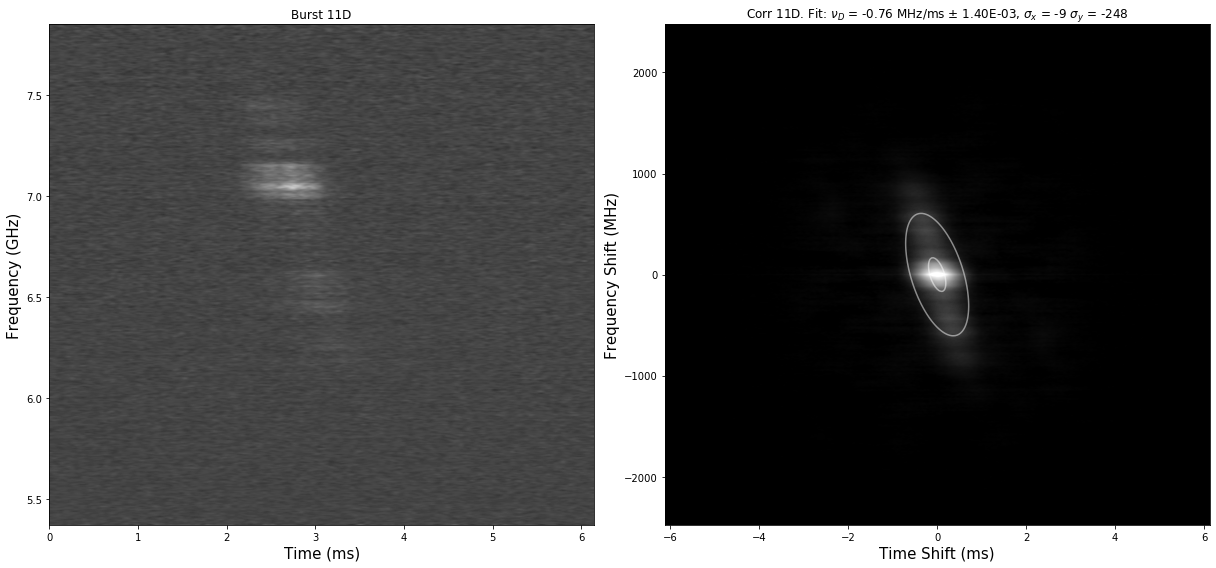

In [111]:
    #### 4. Plot
    cmap = plt.get_cmap('gray')
    cmap.set_bad(color = 'b', alpha = 1.) # potentially hides important errors in the data!

    plt.figure(figsize=(17,8))
    plt.subplot(121)
    plt.title("Burst {}".format(burst))
    
    
    lowestfreq = 6407.7148 - intensity.shape[0]/2*chan_width + chan_width*freqbot # MHz

    burstextents = [0, 
           time_resolution * burstwindow.shape[1] * 1e3, # time, ms
           lowestfreq * 1e-3, # freq, GHz
           (lowestfreq + chan_width*burstwindow.shape[0]) * 1e-3]
    plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", extent=burstextents)
    # plt.clim(0, np.max(burstwindow))
    plt.xlabel("Time (ms)", size=15)
    plt.ylabel("Frequency (GHz)", size=15)
    # plt.colorbar()

    plt.subplot(122)
    plt.title("Corr {}. Fit: $\\nu_D$ = {:.2f} MHz/ms $\pm$ {:.2E}, $\sigma_x$ = {:.0f} $\sigma_y$ = {:.0f}".format(burst, drift, drift_error, popt[3], popt[4]))
    corrextents = [-time_resolution * (corr.shape[1]/2) * 1e3, 
           time_resolution * (corr.shape[1]/2) * 1e3 , 
           - (burstextents[3] - burstextents[2])*1e3, 
           (burstextents[3] - burstextents[2])*1e3]
    print(corrextents)
    plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower", extent=corrextents)
    plt.clim(0, np.max(corr)/10)
    
    plt.xlabel("Time Shift (ms)", size=15)
    plt.ylabel("Frequency Shift (MHz)", size=15)
    # plt.colorbar()
    
    plt.contour(fitmap2, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, origin='lower', extent=corrextents)

    plt.tight_layout()
    plt.savefig('{}/burst_{}_figure.png'.format(outfolder, burst))
    print('saved {}/burst_{}_figure.png'.format(outfolder, burst))

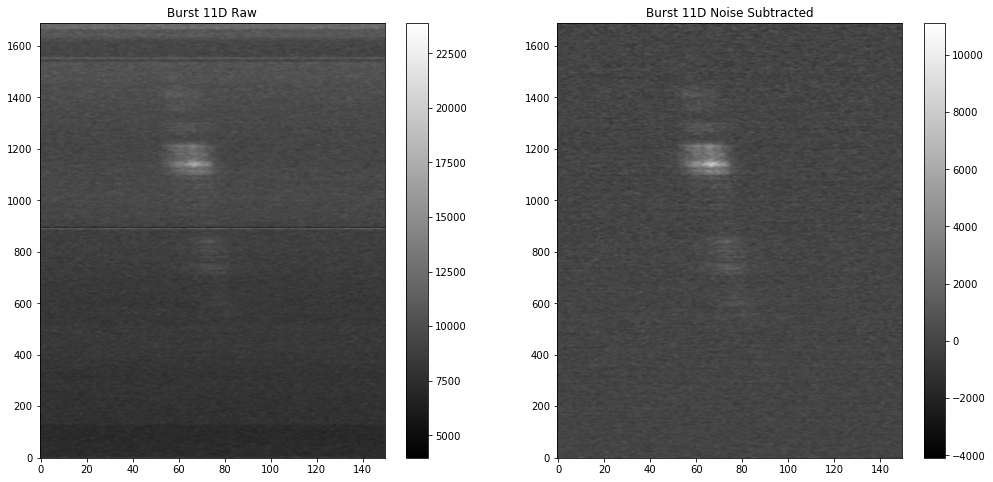

In [22]:
cmap = plt.get_cmap('gray')
# cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
tl,tr = 250,400
plt.figure(figsize=(17,8))

plt.subplot(121)
plt.title("Burst {} Raw".format(burst))
plt.imshow(intensityraw[510:2200,tl:tr], cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
plt.colorbar()

plt.subplot(122)
plt.title("Burst {} Noise Subtracted".format(burst))
# burstextents = [0, 
#        10.24e-6 * burstwindow.shape[-1] * 1e3, 
#        4100.78125 * 1e-3, 
#        (4100.78125 + 1.5625*burstwindow.shape[-2]) * 1e-3]
# plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower", extent=burstextents)

freqbot = 510
freqtop = 2200
noise = intensity[freqbot:freqtop,0:40].mean(axis=1)[:, None]
burstwindow = intensity[freqbot:freqtop,tl:tr] - 1*noise
plt.imshow(burstwindow, cmap=cmap, interpolation='bicubic',aspect='auto', origin="lower")
# plt.xlabel("Time (ms)", size=15)
# plt.ylabel("Frequency (GHz)", size=15)
plt.colorbar()
# plt.clim(0, 25000)


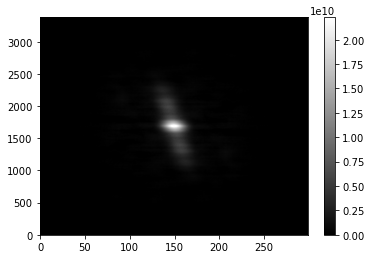

In [28]:
plt.imshow(corr, cmap=cmap, interpolation='bicubic', aspect='auto', origin="lower")
plt.clim(0, np.max(corr)/10)
plt.colorbar()